# Preprocessing Dual Energy Carbonate CT Data

Before running the Monte Carlo inversion, we need to perform some pre-configurations. 
In this tutorial, we will process this data directly within the Jupyter Notebook, 
in a parallel MPI environment using [ipyparallel](https://ipyparallel.readthedocs.io/).

Let's first create a cluster with a set of 5 MPI engines:

In [1]:
import ipyparallel as ipp

# Create an MPI cluster with 5 engines
cluster = ipp.Cluster(engines="mpi", n=5)

# Start and connect to the cluster
rc = cluster.start_and_connect_sync()

# Enable IPython magics for parallel processing
rc[:].activate()

Starting 5 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/5 [00:00<?, ?engine/s]

This will enable the `%%px` 
[cell magic](https://ipyparallel.readthedocs.io/en/latest/examples/Parallel%20Magics.html#px-cell-magic), 
which allows RockVerse to perform parallel processing interactively within this Jupyter notebook.

Let's create the dual energy group and import the 
[raw images we downloaded from the Digital Rocks Portal](../sample_data/import_C04B21_dualenergy.ipynb):

In [2]:
%%px --block

#-------------- TROCAR CHUNK SHAPE -------#
import matplotlib.pyplot as plt
from IPython.display import display
import rockverse as rv

# Create the Dual Energy CT group
dectgroup = rv.dualenergyct.create_group(
    #store='/path/to/dual_energy_ct/C04B21',
    store='/estgf_dados/P_D/GOB7/testemunhos/C04B21_DGX',
    overwrite=True)

# Copy the low energy CT image
dectgroup.copy_image(
    #image=rv.open(store='/path/to/imported/dual_energy_carbonate/C04B21Raw100keV'),
    image=rv.open(store='/estgf_dados/P_D/GOB7/testemunhos/C04B21Raw100keV.zarr'),
    name='lowECT',
    overwrite=True)

# Copy the high energy CT image
dectgroup.copy_image(
    #image=rv.open(store='/path/to/imported/dual_energy_carbonate/C04B21Raw140keV'),
    image=rv.open(store='/estgf_dados/P_D/GOB7/testemunhos/C04B21Raw140keV.zarr'),
    name='highECT',
    overwrite=True)


%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

[stdout:0] [2025-02-17 16:37:24] Copying: 100% 8/8 [00:02<00:00,  3.16chunk/s]
[2025-02-17 16:37:28] Copying: 100% 8/8 [00:02<00:00,  3.26chunk/s]


Now, let's take a quick look at the data using the orthogonal viewer:

In [3]:
%%px --block

# Create orthogonal viewers for low and high energy images
#lowE_viewer = rv.OrthogonalViewer(image=dectgroup.lowECT)
#highE_viewer = rv.OrthogonalViewer(image=dectgroup.highECT)

#Each process will create it's own repeated image, let's close all but rank zero:
#if rv.config.mpi_rank != 0:
#    plt.close(lowE_viewer.figure)
#    plt.close(highE_viewer.figure)


## Building the segmentation and mask images

We could use the ``copy_image`` method to bring segmentation and mask images into the ``dectgroup``, similar to what we just did with the X-ray tomograms (see the method documentation for details).

A segmentation image is used to inform RockVerse about the spatial location of the standard materials for histogram calculations and can be used to perform inversion only at selected segmentation phases. The mask image in the ``dectgroup`` will instruct RockVerse to ignore masked voxels during the inversion process.

While the segmentation image is not available in the Digital Rocks Portal, the rock sample and the standard materials are fairly aligned with the image's z-axis. Let's quickly build a segmentation image using RockVerse's cylindrical regions.

A little trial and error is all it takes in this case:

### Air region

In [4]:
%%px --block --group-outputs=type

#Adjusting viewer properties will help us in this task
#highE_viewer.figure.set_size_inches(10, 10)
#highE_viewer.update_image_dict(clim=(-1200, 3000))
#highE_viewer.mask_color = 'gold'
#highE_viewer.mask_alpha = 0.5

#This is the final cylindrical region for probing air attenuation
air_region = rv.region.Cylinder(p=(126, 20, 461), v=(0, 0, 1), r=10, l=750)

# Set the region in the viewer and visualize the result
#highE_viewer.region = air_region

#Changing region rebuilds the histogram. Let's set the scale again
#highE_viewer.ax_histogram.set_xlim(-1250, 3050)

# Only display the figure for rank 0
#if rv.config.mpi_rank == 0:
#    display(highE_viewer.figure)

### Water region

In [5]:
%%px --block --group-outputs=type

#Final water region
water_region = rv.region.Cylinder(p=(55, 176.2, 461), v=(0, 0, 1), r=10, l=900)

#Adjust the viewer and display for rank 0
#highE_viewer.region = water_region
#highE_viewer.ref_point = water_region.p
#highE_viewer.ax_histogram.set_xlim(-1250, 3050)

#if rv.config.mpi_rank == 0:
#    display(highE_viewer.figure)

### Teflon region

In [6]:
%%px --block --group-outputs=type

#Final teflon region
teflon_region = rv.region.Cylinder(p=(124.7, 228, 461), v=(0, 0, 1), r=6.5, l=900)

#Adjust the viewer and display for rank 0
#highE_viewer.region = teflon_region
#highE_viewer.ref_point = teflon_region.p
#highE_viewer.ax_histogram.set_xlim(-1250, 3050)

#if rv.config.mpi_rank == 0:
#    display(highE_viewer.figure)

### Silica region

In [7]:
%%px --block --group-outputs=type

#Final silica region
silica_region = rv.region.Cylinder(p=(196, 179, 461), v=(0, 0, 1), r=8.5, l=900)

#Adjust the viewer and display for rank 0
#highE_viewer.region = silica_region
#highE_viewer.ref_point = silica_region.p
#highE_viewer.ax_histogram.set_xlim(-1250, 3050)

#if rv.config.mpi_rank == 0:
#    display(highE_viewer.figure)

### Rock sample region

In [8]:
%%px --block --group-outputs=type

#Final rock region
rock_region = rv.region.Cylinder(p=(126, 114, 461), v=(0, 0, 1), r=63, l=875)

#Adjust the viewer and display for rank 0
#highE_viewer.region = rock_region
#highE_viewer.ref_point = rock_region.p
#highE_viewer.ax_histogram.set_xlim(-1250, 3050)

#if rv.config.mpi_rank == 0:
#    display(highE_viewer.figure)

### Combined segmentation image

Now, we can use these regions to create the final segmentation image:

In [9]:
%%px --block --group-outputs=type

# Create the segmentation voxel image inside the dual energy group
dectgroup.create_segmentation(fill_value=0, overwrite=True)

# Use the VoxelImage math method to assign each region
dectgroup.segmentation.math(value=1, op='set', region=air_region)    #Air
dectgroup.segmentation.math(value=2, op='set', region=water_region)  #Water
dectgroup.segmentation.math(value=3, op='set', region=teflon_region) #Teflon
dectgroup.segmentation.math(value=4, op='set', region=silica_region) #Silica
dectgroup.segmentation.math(value=5, op='set', region=rock_region)   #Rock sample

#Adjust the viewer and display for rank 0
#highE_viewer.region = None
#highE_viewer.segmentation = dectgroup.segmentation
#highE_viewer.ref_point = rock_region.p
#highE_viewer.ax_histogram.set_xlim(-1250, 3050)

#if rv.config.mpi_rank == 0:
#    display(highE_viewer.figure)

[stdout:0] [2025-02-17 16:37:31] (segmentation) Set: 100% 8/8 [00:02<00:00,  3.23chunk/s]
[2025-02-17 16:37:35] (segmentation) Set: 100% 8/8 [00:00<00:00, 16.21chunk/s]
[2025-02-17 16:37:36] (segmentation) Set: 100% 8/8 [00:00<00:00, 15.23chunk/s]
[2025-02-17 16:37:37] (segmentation) Set: 100% 8/8 [00:00<00:00, 16.05chunk/s]
[2025-02-17 16:37:38] (segmentation) Set: 100% 8/8 [00:00<00:00, 16.09chunk/s]


%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

### Adjusting histogram bins

It is clear from the image that the default value for the number of histogram bins results in a crude histogram. We need to calculate a more detailed histogram, as the histogram counts will serve as the basis for calculating the probability density functions for the X-ray attenuation values in the standard materials.

Once again, some testing led to the final choice of $2^{10}$ bins.
Let's update our DECT group and our viewer:

In [10]:
%%px --block

# Set the new number of histogram bins
#highE_viewer.histogram_bins = 2**10

# Fix the plot scale, as the previous line triggers new histogram calculation
#highE_viewer.ax_histogram.set_xlim(-1250, 3050)
#highE_viewer.ax_histogram.set_ylim(0, 2.1e7)

#if rv.config.mpi_rank == 0:
#    display(highE_viewer.figure)

### Mask Image

Now let's define an image mask to save time in the Monte Carlo inversion by masking out voxels for which we are not interested in the results. While we cannot assign RockVerse regions of interest to DualEnergyCT groups, we can create an arbitrary mask voxel image to inform RockVerse which voxels should be ignored.

If you have a mask image somewhere, you can import it into the ``dualenergyct`` group using the ``copy_image`` method. In our case, phase 0 in our segmentation image represents the regions we want to exclude from our inversion, so the ``create_mask`` method is all we need:


In [11]:
%%px --block --group-outputs=type

#Create the empty mask
dectgroup.create_mask(fill_value=False, overwrite=True)

#Use VoxelImage math method to set mask to True where segmentation is 0
dectgroup.mask.math(value=True,
                    op='set',
                    segmentation=dectgroup.segmentation,
                    phases=(0,))

#Adjust the viewer and display for rank 0
#highE_viewer.mask = dectgroup.mask
#highE_viewer.mask_color = 'k'
#highE_viewer.mask_alpha = 0.75
#highE_viewer.ax_histogram.set_xlim(-1250, 3050)

#if rv.config.mpi_rank == 0:
#    display(highE_viewer.figure)


[stdout:0] [2025-02-17 16:37:39] (mask) Set: 100% 8/8 [00:00<00:00, 10.41chunk/s]


The black voxels in the image above will be ignored during the Monte Carlo inversion.
Let's rebuild both viewers with all the updates so far:

[stdout:0] [2025-02-17 16:37:41] Histogram Low attenuation (min/max): 100% 8/8 [00:02<00:00,  2.96chunk/s]
[2025-02-17 16:37:43] Histogram Low attenuation (reading segmentation): 100% 8/8 [00:00<00:00, 45.27chunk/s]
[2025-02-17 16:37:44] Histogram Low attenuation (counting voxels): 100% 8/8 [00:02<00:00,  3.82chunk/s]
[2025-02-17 16:37:52] Histogram High attenuation (min/max): 100% 8/8 [00:00<00:00, 11.00chunk/s]
[2025-02-17 16:37:53] Histogram High attenuation (reading segmentation): 100% 8/8 [00:00<00:00, 125.04chunk/s]
[2025-02-17 16:37:53] Histogram High attenuation (counting voxels): 100% 8/8 [00:01<00:00,  4.48chunk/s]


%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

[output:0]

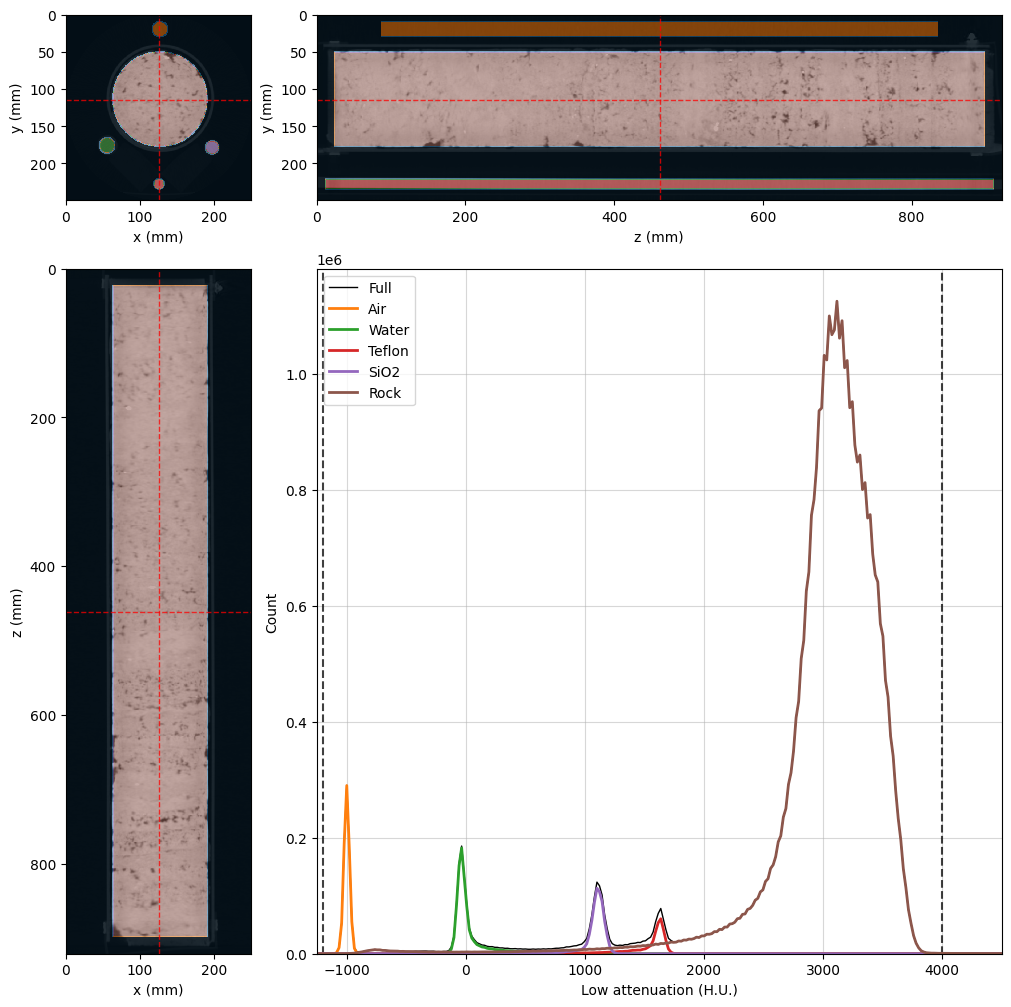

[output:0]

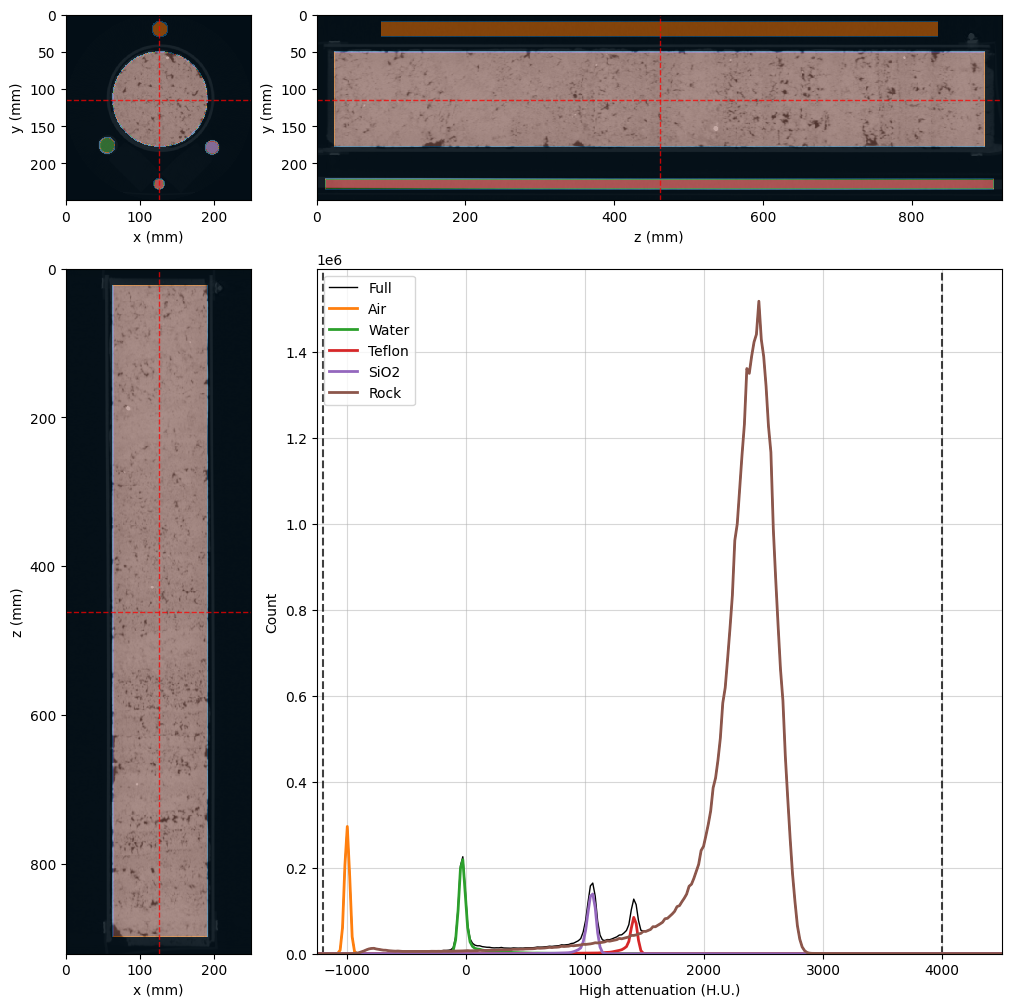

In [12]:
%%px --block --group-outputs=type

#Common properties can be set at once at OrthogonalViewer creation
kwargs = {
    'region': None,
    'mask': dectgroup.mask,
    'mask_color': 'k',
    'mask_alpha': 0.75,
    'histogram_bins': 2**10,
    'segmentation': dectgroup.segmentation,
    'ref_point': rock_region.p,
}

lowE_viewer = rv.OrthogonalViewer(image=dectgroup.lowECT, **kwargs)
highE_viewer = rv.OrthogonalViewer(image=dectgroup.highECT, **kwargs)

#Fine tunning
for viewer in [lowE_viewer, highE_viewer]:
    viewer.figure.set_size_inches(10, 10)        #figure size
    viewer.update_image_dict(clim=(-1200, 4000)) #X-ray CT clims
    viewer.ax_histogram.set_xlim(-1250, 4500)    #Histogram limits
    #Set segmentation names in the legend labels
    viewer.ax_histogram.legend(
        [
            highE_viewer.histogram_lines['full'],
            highE_viewer.histogram_lines['1'],
            highE_viewer.histogram_lines['2'],
            highE_viewer.histogram_lines['3'],
            highE_viewer.histogram_lines['4'],
            highE_viewer.histogram_lines['5'],
        ], [
            'Full',
            'Air',
            'Water',
            'Teflon',
            'SiO2',
            'Rock'
        ]
    )

#Close all but rank 0
if rv.config.mpi_rank != 0:
    plt.close(lowE_viewer.figure)
    plt.close(highE_viewer.figure)



## Filling Standard Material Information

The next step is to populate the information and the X-ray attenuation probability density functions (pdf) for the standard materials. The pdfs have to passed as a two-element list or tuple with the x (attenuation values) and y (pdf values) arrays for the pdf model. 
The pdf array (y) does not need to be normalized. RockVerse will take care of the normalization when assigning the values.

We could use the histogram values themselves, but due to our lazy segmentation in this tutorial, we'll model a Gaussian distribution after each segmentation histogram to filter out spurious values and border voxels. We'll use the RockVerse optimization module for this task.

### Air

%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

[output:0]

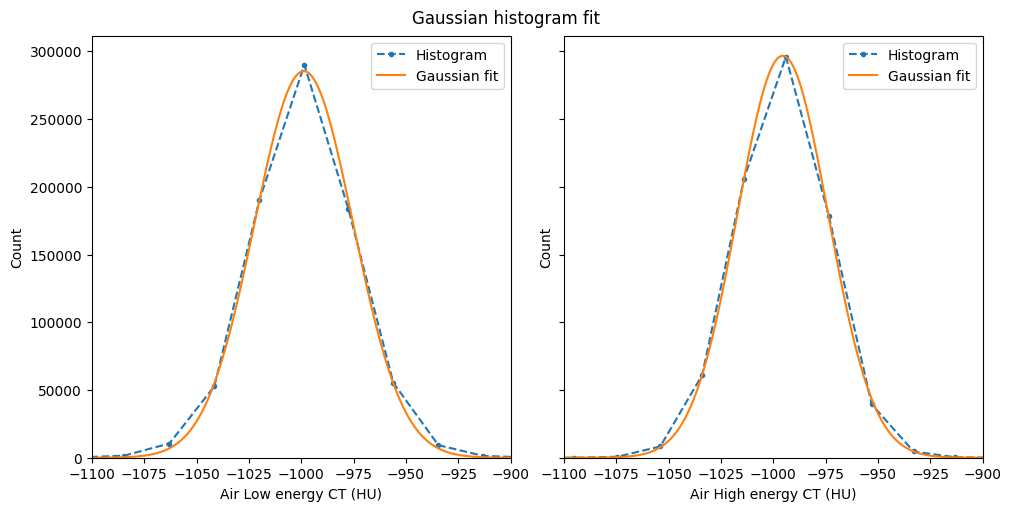

[output:0]

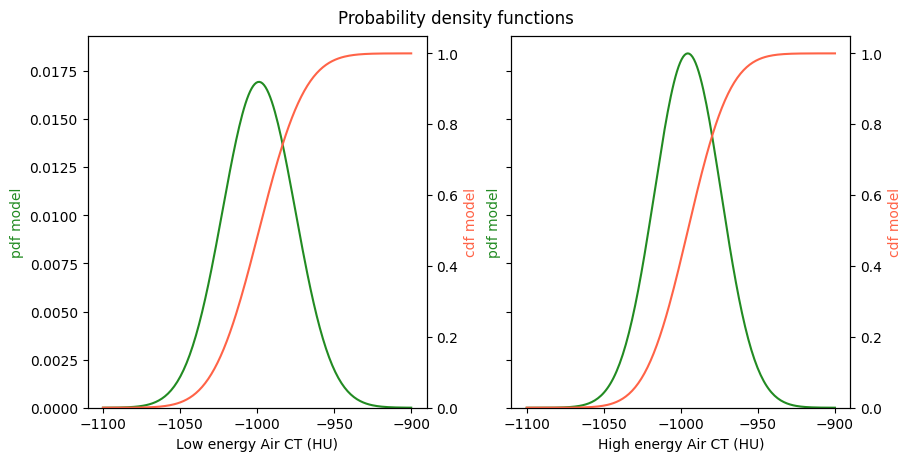

In [13]:
%%px --block

import numpy as np
from rockverse.optimize import gaussian_fit, gaussian_val

seg_phase = 1 # Air is segmentation phase 1
cm_index = 0  # Standard material 0 is empty space
name = 'Air'

x_low = lowE_viewer.histogram.bin_centers
y_low = lowE_viewer.histogram.count[seg_phase].values
x_high = highE_viewer.histogram.bin_centers
y_high = highE_viewer.histogram.count[seg_phase].values

# Call gaussian_fit to get fitting parameters
c_low = gaussian_fit(x_low, y_low)
c_high = gaussian_fit(x_high, y_high)

# We'll build a fine-spaced histogram axis and call
# gaussian_val to build the gaussian curve.
# It is important to go and sample regions
# with pdf values close to zero
xlim = (-1100, -900)
x_fit = np.linspace(*xlim, 200)
y_fit_low = gaussian_val(c_low, x_fit)
y_fit_high = gaussian_val(c_high, x_fit)

#Let's check the Gaussian fit:
if mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Gaussian histogram fit')

    for k, (x, y, yfit, E) in enumerate(zip((x_low, x_high),
                                            (y_low, y_high),
                                            (y_fit_low, y_fit_high),
                                            ('Low', 'High'))):

        ax[k].plot(x, y, '.--', label='Histogram')
        ax[k].plot(x_fit, yfit, '-', label='Gaussian fit')
        ax[k].set_xlabel(f'{name} {E} energy CT (HU)')
        ax[k].set_xlim(xlim)
        ax[k].legend()
        ax[k].set_ylabel('Count')
    ax[0].set_ylim(ymin=0)

# Now fill in necessary fields in dectgroup
# Note: setting or getting pdf's is a collective MPI call,
# make sure all the processes run it (e.g. don't use if 'mpi_rank == 0')
dectgroup.calibration_material[cm_index].description = name
dectgroup.calibration_material[cm_index].lowE_pdf = (x_fit, y_fit_low)
dectgroup.calibration_material[cm_index].highE_pdf = (x_fit, y_fit_high)

# RockVerse will normalize the pdf values before assigning them.
# Let's check that also (again, make sure all processes run these two lines)
x_lowE_pdf, y_lowE_pdf = dectgroup.calibration_material[cm_index].lowE_pdf
_, cdf_low = dectgroup.calibration_material[cm_index].lowE_cdf

x_highE_pdf, y_highE_pdf = dectgroup.calibration_material[cm_index].highE_pdf
_, cdf_high = dectgroup.calibration_material[cm_index].highE_cdf

if rv.config.mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(9, 4.5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Probability density functions')

    for k, (x, y, c, E) in enumerate(zip((x_lowE_pdf, x_highE_pdf),
                                         (y_lowE_pdf, y_highE_pdf),
                                         (cdf_low, cdf_high),
                                         ('Low', 'High'))):
        ax[k].plot(x, y, color='forestgreen')
        ax[k].set_xlabel(f'{E} energy Air CT (HU)')
        ax[k].set_ylabel('pdf model', color='forestgreen')
        ax_cdf = ax[k].twinx()
        ax_cdf.plot(x, c, color='tomato')
        ax_cdf.set_ylabel('cdf model', color='tomato')
        ax_cdf.set_ylim(ymin=0)
    ax[0].set_ylim(ymin=0)


Now let's replicate to the other standard materials.

### Water

[output:0]

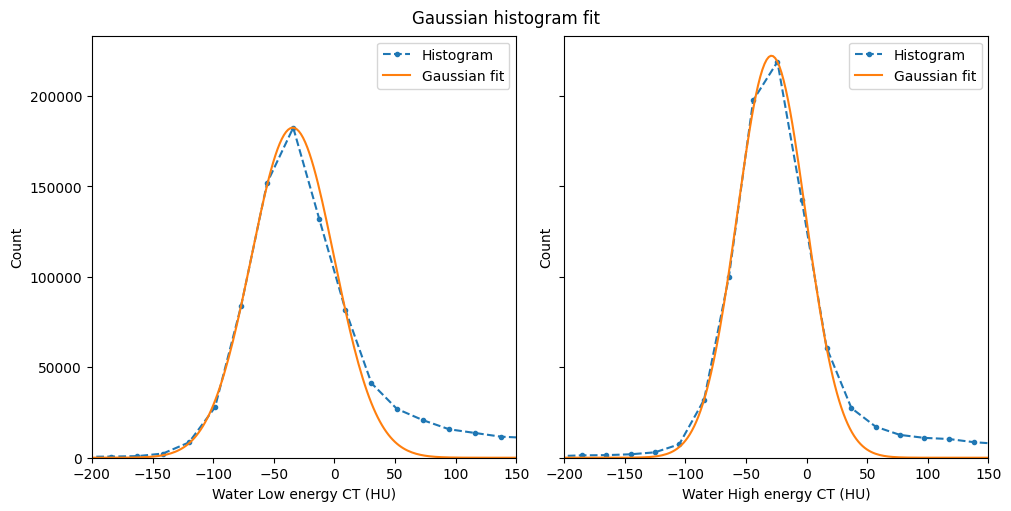

[output:0]

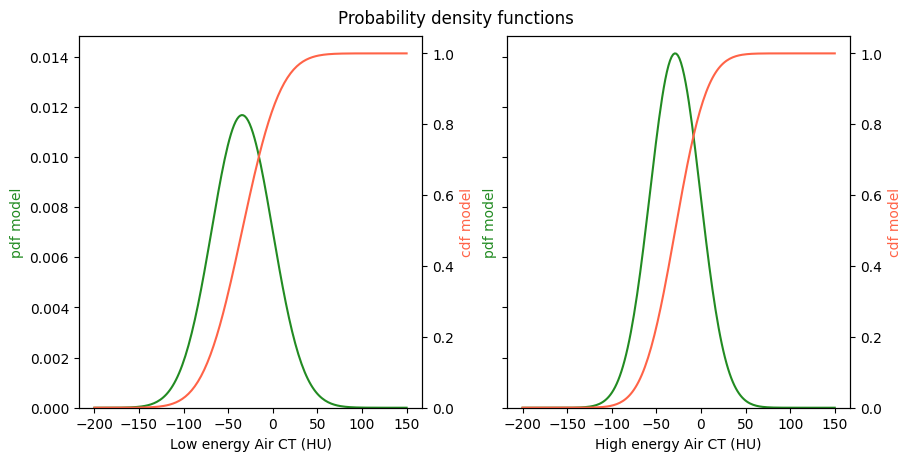

In [14]:
%%px --block

seg_phase = 2 # Water is segmentation phase 1
cm_index = 1  # We'll assign water to calibration material 1
name = 'Water'
bulk_density = 1.
composition = {'H': 2, 'O': 1}

x_low = lowE_viewer.histogram.bin_centers
y_low = lowE_viewer.histogram.count[seg_phase].values
x_high = highE_viewer.histogram.bin_centers
y_high = highE_viewer.histogram.count[seg_phase].values

# Call gaussian_fit to get fitting parameters
c_low = gaussian_fit(x_low, y_low)
c_high = gaussian_fit(x_high, y_high)

# We'll build a fine-spaced histogram axis and call
# gaussian_val to build the gaussian curve.
# It is important to go and sample regions
# with pdf values close to zero
xlim = (-200, 150)
x_fit = np.linspace(*xlim, 200)
y_fit_low = gaussian_val(c_low, x_fit)
y_fit_high = gaussian_val(c_high, x_fit)

#Let's check the Gaussian fit:
if mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Gaussian histogram fit')

    for k, (x, y, yfit, E) in enumerate(zip((x_low, x_high),
                                            (y_low, y_high),
                                            (y_fit_low, y_fit_high),
                                            ('Low', 'High'))):

        ax[k].plot(x, y, '.--', label='Histogram')
        ax[k].plot(x_fit, yfit, '-', label='Gaussian fit')
        ax[k].set_xlabel(f'{name} {E} energy CT (HU)')
        ax[k].set_xlim(xlim)
        ax[k].legend()
        ax[k].set_ylabel('Count')
    ax[0].set_ylim(ymin=0)

# Now fill in necessary fields in dectgroup
# Note: setting or getting pdf's is a collective MPI call,
# make sure all the processes run it (e.g. don't use if 'mpi_rank == 0')
dectgroup.calibration_material[cm_index].description = name
dectgroup.calibration_material[cm_index].lowE_pdf = (x_fit, y_fit_low)
dectgroup.calibration_material[cm_index].highE_pdf = (x_fit, y_fit_high)
dectgroup.calibration_material[cm_index].bulk_density = bulk_density
dectgroup.calibration_material[cm_index].composition = composition

# RockVerse will normalize the pdf values before assigning them.
# Let's check that also (again, make sure all processes run these two lines)
x_lowE_pdf, y_lowE_pdf = dectgroup.calibration_material[cm_index].lowE_pdf
_, cdf_low = dectgroup.calibration_material[cm_index].lowE_cdf

x_highE_pdf, y_highE_pdf = dectgroup.calibration_material[cm_index].highE_pdf
_, cdf_high = dectgroup.calibration_material[cm_index].highE_cdf

if rv.config.mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(9, 4.5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Probability density functions')

    for k, (x, y, c, E) in enumerate(zip((x_lowE_pdf, x_highE_pdf),
                                         (y_lowE_pdf, y_highE_pdf),
                                         (cdf_low, cdf_high),
                                         ('Low', 'High'))):
        ax[k].plot(x, y, color='forestgreen')
        ax[k].set_xlabel(f'{E} energy Air CT (HU)')
        ax[k].set_ylabel('pdf model', color='forestgreen')
        ax_cdf = ax[k].twinx()
        ax_cdf.plot(x, c, color='tomato')
        ax_cdf.set_ylabel('cdf model', color='tomato')
        ax_cdf.set_ylim(ymin=0)
    ax[0].set_ylim(ymin=0)

### Silica

[output:0]

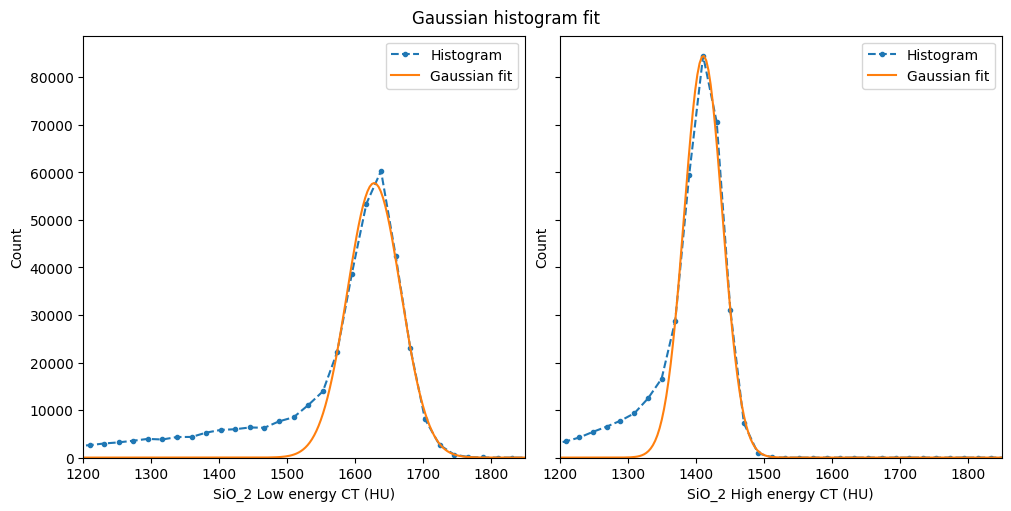

[output:0]

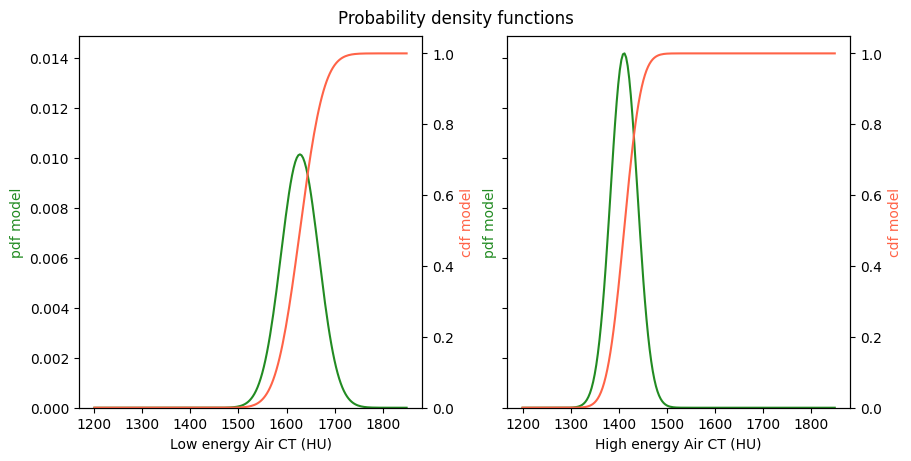

In [15]:
%%px --block

seg_phase = 3 # Silica is segmentation phase 3
cm_index = 2  # We'll assign silica to calibration material 2
name = 'SiO_2'
bulk_density = 2.2
composition = {'Si': 1, 'O': 2}

x_low = lowE_viewer.histogram.bin_centers
y_low = lowE_viewer.histogram.count[seg_phase].values
x_high = highE_viewer.histogram.bin_centers
y_high = highE_viewer.histogram.count[seg_phase].values

# Call gaussian_fit to get fitting parameters
c_low = gaussian_fit(x_low, y_low)
c_high = gaussian_fit(x_high, y_high)

# We'll build a fine-spaced histogram axis and call
# gaussian_val to build the gaussian curve.
# It is important to go and sample regions
# with pdf values close to zero
xlim = (1200, 1850)
x_fit = np.linspace(*xlim, 200)
y_fit_low = gaussian_val(c_low, x_fit)
y_fit_high = gaussian_val(c_high, x_fit)

#Let's check the Gaussian fit:
if mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Gaussian histogram fit')

    for k, (x, y, yfit, E) in enumerate(zip((x_low, x_high),
                                            (y_low, y_high),
                                            (y_fit_low, y_fit_high),
                                            ('Low', 'High'))):

        ax[k].plot(x, y, '.--', label='Histogram')
        ax[k].plot(x_fit, yfit, '-', label='Gaussian fit')
        ax[k].set_xlabel(f'{name} {E} energy CT (HU)')
        ax[k].set_xlim(xlim)
        ax[k].legend()
        ax[k].set_ylabel('Count')
    ax[0].set_ylim(ymin=0)

# Now fill in necessary fields in dectgroup
# Note: setting or getting pdf's is a collective MPI call,
# make sure all the processes run it (e.g. don't use if 'mpi_rank == 0')
dectgroup.calibration_material[cm_index].description = name
dectgroup.calibration_material[cm_index].lowE_pdf = (x_fit, y_fit_low)
dectgroup.calibration_material[cm_index].highE_pdf = (x_fit, y_fit_high)
dectgroup.calibration_material[cm_index].bulk_density = bulk_density
dectgroup.calibration_material[cm_index].composition = composition

# RockVerse will normalize the pdf values before assigning them.
# Let's check that also (again, make sure all processes run these two lines)
x_lowE_pdf, y_lowE_pdf = dectgroup.calibration_material[cm_index].lowE_pdf
_, cdf_low = dectgroup.calibration_material[cm_index].lowE_cdf

x_highE_pdf, y_highE_pdf = dectgroup.calibration_material[cm_index].highE_pdf
_, cdf_high = dectgroup.calibration_material[cm_index].highE_cdf

if rv.config.mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(9, 4.5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Probability density functions')

    for k, (x, y, c, E) in enumerate(zip((x_lowE_pdf, x_highE_pdf),
                                         (y_lowE_pdf, y_highE_pdf),
                                         (cdf_low, cdf_high),
                                         ('Low', 'High'))):
        ax[k].plot(x, y, color='forestgreen')
        ax[k].set_xlabel(f'{E} energy Air CT (HU)')
        ax[k].set_ylabel('pdf model', color='forestgreen')
        ax_cdf = ax[k].twinx()
        ax_cdf.plot(x, c, color='tomato')
        ax_cdf.set_ylabel('cdf model', color='tomato')
        ax_cdf.set_ylim(ymin=0)
    ax[0].set_ylim(ymin=0)

### Teflon

[output:0]

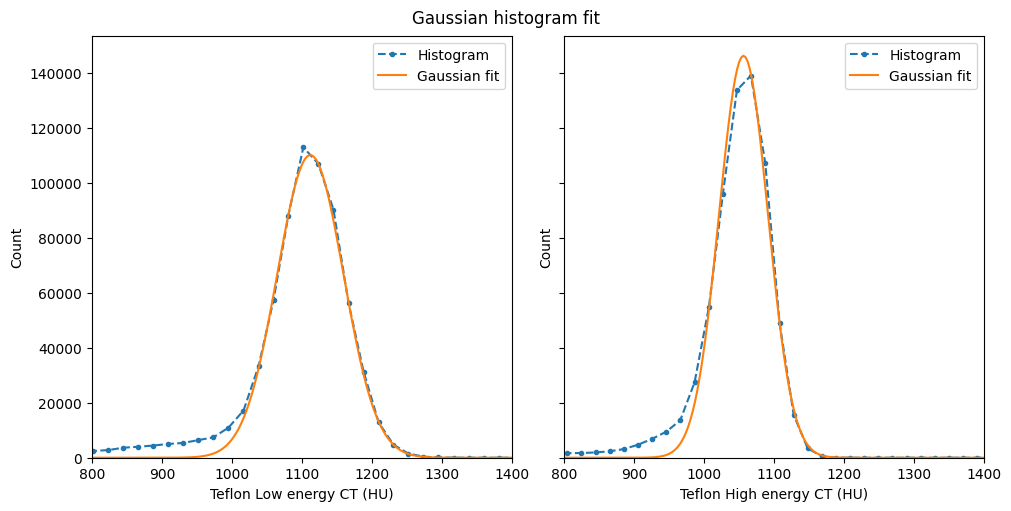

[output:0]

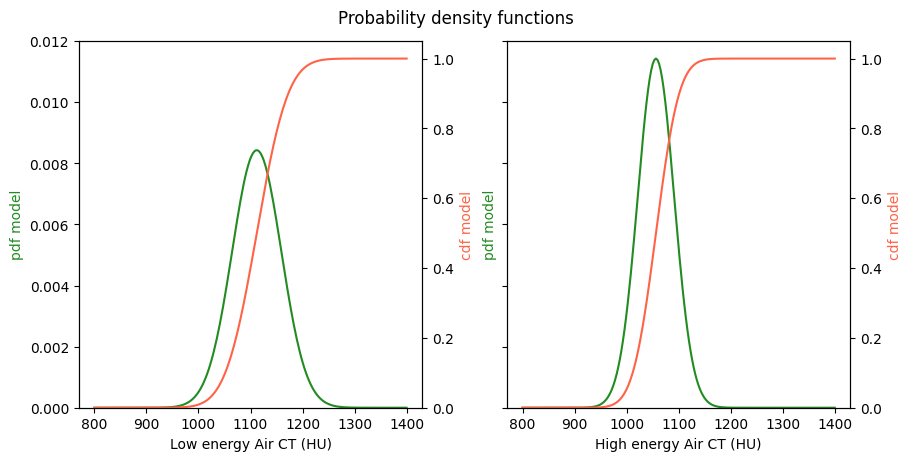

In [16]:
%%px --block

seg_phase = 4 # Teflon is segmentation phase 4
cm_index = 3  # We'll assign teflon to calibration material 3
name = 'Teflon'
bulk_density = 2.2
composition = {'C': 2, 'F': 4}

x_low = lowE_viewer.histogram.bin_centers
y_low = lowE_viewer.histogram.count[seg_phase].values
x_high = highE_viewer.histogram.bin_centers
y_high = highE_viewer.histogram.count[seg_phase].values

# Call gaussian_fit to get fitting parameters
c_low = gaussian_fit(x_low, y_low)
c_high = gaussian_fit(x_high, y_high)

# We'll build a fine-spaced histogram axis and call
# gaussian_val to build the gaussian curve.
# It is important to go and sample regions
# with pdf values close to zero
xlim = (800, 1400)
x_fit = np.linspace(*xlim, 200)
y_fit_low = gaussian_val(c_low, x_fit)
y_fit_high = gaussian_val(c_high, x_fit)

#Let's check the Gaussian fit:
if mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Gaussian histogram fit')

    for k, (x, y, yfit, E) in enumerate(zip((x_low, x_high),
                                            (y_low, y_high),
                                            (y_fit_low, y_fit_high),
                                            ('Low', 'High'))):

        ax[k].plot(x, y, '.--', label='Histogram')
        ax[k].plot(x_fit, yfit, '-', label='Gaussian fit')
        ax[k].set_xlabel(f'{name} {E} energy CT (HU)')
        ax[k].set_xlim(xlim)
        ax[k].legend()
        ax[k].set_ylabel('Count')
    ax[0].set_ylim(ymin=0)

# Now fill in necessary fields in dectgroup
# Note: setting or getting pdf's is a collective MPI call,
# make sure all the processes run it (e.g. don't use if 'mpi_rank == 0')
dectgroup.calibration_material[cm_index].description = name
dectgroup.calibration_material[cm_index].lowE_pdf = (x_fit, y_fit_low)
dectgroup.calibration_material[cm_index].highE_pdf = (x_fit, y_fit_high)
dectgroup.calibration_material[cm_index].bulk_density = bulk_density
dectgroup.calibration_material[cm_index].composition = composition

# RockVerse will normalize the pdf values before assigning them.
# Let's check that also (again, make sure all processes run these two lines)
x_lowE_pdf, y_lowE_pdf = dectgroup.calibration_material[cm_index].lowE_pdf
_, cdf_low = dectgroup.calibration_material[cm_index].lowE_cdf

x_highE_pdf, y_highE_pdf = dectgroup.calibration_material[cm_index].highE_pdf
_, cdf_high = dectgroup.calibration_material[cm_index].highE_cdf


if rv.config.mpi_rank == 0:
    fig, ax = plt.subplots(1, 2, figsize=(9, 4.5),
                           layout='constrained',
                           sharex=True, sharey=True)
    fig.suptitle('Probability density functions')

    for k, (x, y, c, E) in enumerate(zip((x_lowE_pdf, x_highE_pdf),
                                         (y_lowE_pdf, y_highE_pdf),
                                         (cdf_low, cdf_high),
                                         ('Low', 'High'))):
        ax[k].plot(x, y, color='forestgreen')
        ax[k].set_xlabel(f'{E} energy Air CT (HU)')
        ax[k].set_ylabel('pdf model', color='forestgreen')
        ax_cdf = ax[k].twinx()
        ax_cdf.plot(x, c, color='tomato')
        ax_cdf.set_ylabel('cdf model', color='tomato')
        ax_cdf.set_ylim(ymin=0)
    ax[0].set_ylim(ymin=0)

## Run the preprocessing step

Now we are ready to set the processing parameters and run the pre-processing step.
Our little cluster with 5 MPI processes is still enough for this task.

In [17]:
%%px --block

# Call the preprocess method
# This will check all bla bla bla
dectgroup.preprocess()

[stdout:0] [2025-02-17 16:38:14] Hashing Low attenuation: 100% 8/8 [00:00<00:00, 18.09chunk/s]
[2025-02-17 16:38:15] Hashing High attenuation: 100% 8/8 [00:00<00:00, 19.13chunk/s]
[2025-02-17 16:38:15] Hashing mask: 100% 8/8 [00:00<00:00, 60.26chunk/s]
[2025-02-17 16:38:15] Hashing segmentation: 100% 8/8 [00:00<00:00, 55.63chunk/s]
[2025-02-17 16:38:16] Generating inversion coefficients: 100% 100000/100000 [00:42<00:00, 2373.07/s]


%px:   0%|          | 0/5 [00:00<?, ?tasks/s]

### Appraisal

Let's take a look at the preprocessing results. 
This time, we will work locally instead of in the ipyparallel cluster,
so we need to load the libraries and the DECT group again.


In [18]:
# Note that we are not using the %%px cell magic anymore!
# Now the process will run locally, so we nee to start over

import matplotlib.pyplot as plt
import numpy as np
import rockverse as rv

#Load the DECT group
#dectgroup = rv.open(r'/path/to/dual_energy_ct/C04B21')
dectgroup = rv.open('/estgf_dados/P_D/GOB7/testemunhos/C04B21_DGX')


[s6506ggfdgx03:1542014] mca:base:process_repository_item filename /estgf_dados/P_D/GOB7/mambaforge/envs/rockverse-zarr3/lib/pmix/ has bad prefix - expected:
	pmix_mca_
or
	libpmix_mca_
--------------------------------------------------------------------------
Open MPI failed an OFI Libfabric library call (fi_endpoint).  This is highly
unusual; your job may behave unpredictably (and/or abort) after this.

  Local host: s6506ggfdgx03
  Location: mtl_ofi_component.c:515
  Error: No data available (61)
--------------------------------------------------------------------------
[s6506ggfdgx03:1542014] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.s6506ggfdgx03.7135/jf.0/317652992/shared_mem_cuda_pool.s6506ggfdgx03 could be created.
[s6506ggfdgx03:1542014] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


The results can be accessed through the following attributes:

- ``lowE_inversion_coefficients``: ???
- ``highE_inversion_coefficients``: ???

Let's take a look at each one of them:


In [19]:
print(dectgroup.lowE_inversion_coefficients)

              CT_0       CT_1         CT_2         CT_3       Z_1        Z_2  \
0     -1011.557789 -27.638191  1676.884422  1137.688442  6.613685  10.806699   
1     -1023.618090 -34.673367  1667.085427  1053.266332  7.061322  11.100898   
2      -969.346734 -69.849246  1614.824121  1050.251256  6.571664  10.786422   
3      -972.361809 -32.914573  1680.150754  1152.763819  6.369924  10.699578   
4      -972.361809 -32.914573  1680.150754  1152.763819  6.369924  10.699578   
...            ...        ...          ...          ...       ...        ...   
49995  -989.447236 -11.809045  1660.552764  1107.537688  6.800583  10.909074   
49996  -989.447236 -11.809045  1660.552764  1107.537688  6.800583  10.909074   
49997  -988.442211 -25.879397  1670.351759  1053.266332  7.012464  11.059007   
49998  -995.477387 -52.261307  1657.286432  1050.251256  6.850117  10.940290   
49999  -983.417085   9.296482  1565.829146  1116.582915  6.669707  10.835154   

            Z_3           A           B

In [20]:
print(dectgroup.highE_inversion_coefficients)

              CT_0       CT_1         CT_2         CT_3       Z_1        Z_2  \
0     -1013.567839 -27.638191  1389.447236  1041.206030  6.510545  10.758395   
1     -1011.557789  -4.773869  1441.708543  1062.311558  6.746170  10.876951   
2     -1030.653266   9.296482  1386.180905  1092.462312  6.477134  10.743746   
3      -994.472362   9.296482  1395.979899  1101.507538  6.188328  10.632961   
4     -1014.572864 -11.809045  1422.110553  1014.070352  7.056616  11.096715   
...            ...        ...          ...          ...       ...        ...   
49995  -966.331658 -15.326633  1382.914573  1029.145729  6.500048  10.753743   
49996  -995.477387 -50.502513  1399.246231  1062.311558  6.004343  10.573593   
49997 -1018.592965 -36.432161  1395.979899   980.904523  7.015484  11.061501   
49998  -974.371859 -59.296482  1464.572864  1059.296482  6.164058  10.624711   
49999 -1002.512563 -17.085427  1458.040201  1080.402010  6.456156  10.734774   

            Z_3           A           B

Let's write some code to retrieve these parameters and display some plots:

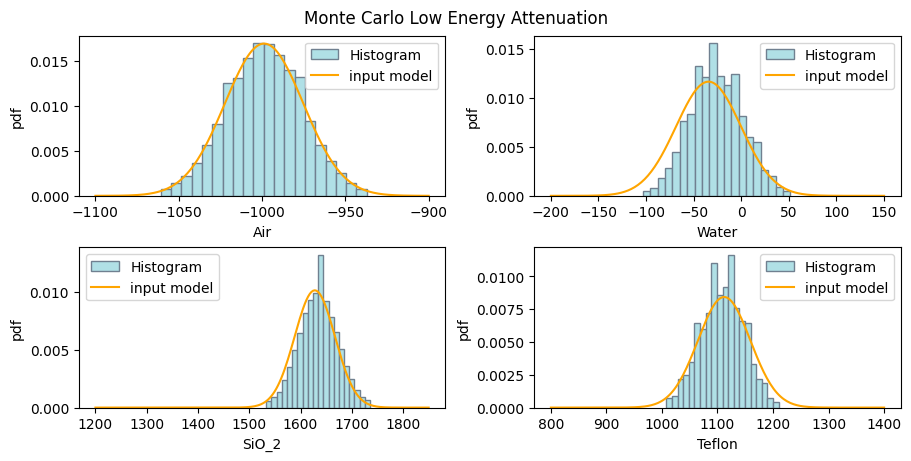

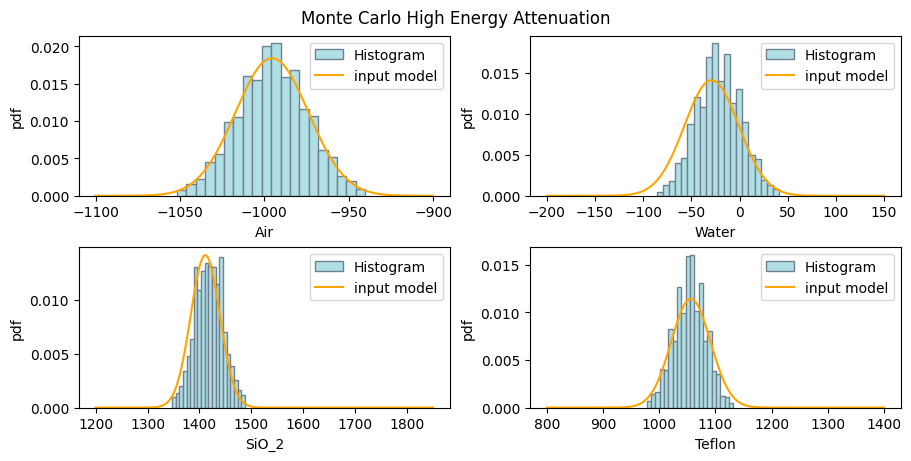

In [21]:
fig1, ax1 = plt.subplots(2, 2, layout='constrained', figsize=(9, 4.5))
fig2, ax2 = plt.subplots(2, 2, layout='constrained', figsize=(9, 4.5))
fig1.suptitle('Monte Carlo Low Energy Attenuation')
fig2.suptitle('Monte Carlo High Energy Attenuation')

for ax, coef, mode in zip((ax1, ax2),
                          (dectgroup.lowE_inversion_coefficients,
                           dectgroup.highE_inversion_coefficients),
                          ('low', 'high')):
    for k, (i, j) in enumerate(zip((0, 0, 1, 1), (0, 1, 0, 1))):
        ax[i][j].hist(coef[f'CT_{k}'],
                      bins=20,
                      density=True,
                      facecolor='powderblue',
                      edgecolor='slategrey',
                      label='Histogram')
        ax[i][j].set_xlabel(dectgroup.calibration_material[k].description)
        ax[i][j].set_ylabel('pdf')
        x_pdf, y_pdf = dectgroup.calibration_material[k].__getattribute__(f'{mode}E_pdf')
        ax[i][j].plot(x_pdf, y_pdf, color='orange', label='input model')
        ax[i][j].legend()


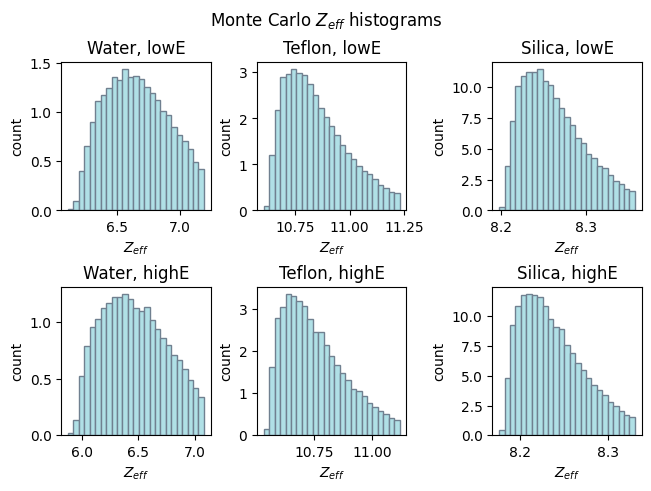

In [22]:
fig1, axs = plt.subplots(2, 3, layout='constrained')
ax1 = axs[0][0], axs[0][1], axs[0][2]
ax2 = axs[1][0], axs[1][1], axs[1][2]
fig1.suptitle('Monte Carlo $Z_{eff}$ histograms')

for ax, coef, mode in (zip((ax1, ax2),
                           (dectgroup.lowE_inversion_coefficients,
                            dectgroup.highE_inversion_coefficients),
                            ('low', 'high'))):
    for k, xlb in enumerate(('Water', 'Teflon', 'Silica')):
        ax[k].hist(coef[f'Z_{k+1}'],
                    bins=25,
                    density=True,
                    facecolor='powderblue',
                    edgecolor='slategrey',
                    label='Hist.')
        ax[k].set_title(f'{xlb}, {mode}E')
        ax[k].set_ylabel('count')
        ax[k].set_xlabel('$Z_{eff}$')


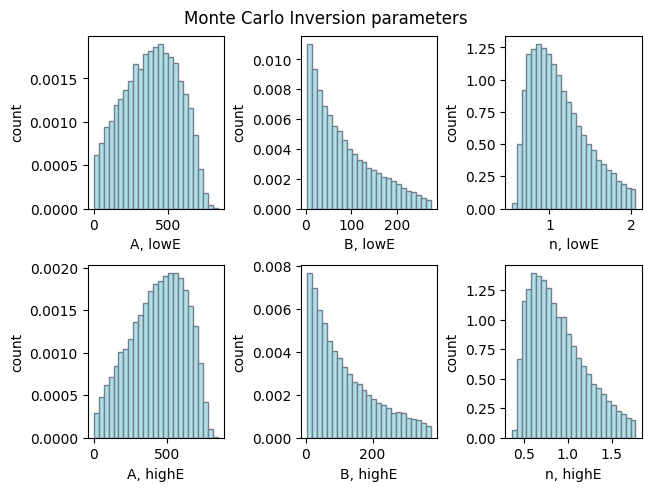

In [23]:
fig1, axs = plt.subplots(2, 3, layout='constrained')
ax1 = axs[0][0], axs[0][1], axs[0][2]
ax2 = axs[1][0], axs[1][1], axs[1][2]
fig1.suptitle('Monte Carlo Inversion parameters')

for ax, coef, mode in (zip((ax1, ax2),
                           (dectgroup.lowE_inversion_coefficients,
                            dectgroup.highE_inversion_coefficients),
                            ('low', 'high'))):
    for k, xlb in enumerate(('A', 'B', 'n')):
        ax[k].hist(coef[f'{xlb}'],
                    bins=25,
                    density=True,
                    facecolor='powderblue',
                    edgecolor='slategrey',
                    label='Hist.')
        ax[k].set_xlabel(f'{xlb}, {mode}E')
        ax[k].set_ylabel('count')

## Run the Monte Carlo inversion

Once we are satisfied with these inversion parameters, we are ready to run the full inversion. 
For this, we only need to execute the following code snippet in a parallel environment:

```python
import rockverse as rv
dectgroup = rv.open(r'/path/to/dual_energy_ct/C04B21')
dectgroup.run()
```

Remember: we are utilizing Monte Carlo in the Digital Rock universe! This process is
computationally intensive and is meant to be run in a high-performance computing environment,
such as a GPU-enabled machine or a handful of nodes in a CPU cluster. If you just want to test
the inversion, you can go back to the mask definition and reduce the cylinder length to
allow the code to work only on a tiny part of the whole image.

After completion, you will have access to the Monte Carlo results through the
following new voxel images as attributes of dectgroup:

- ``rho_min``: Voxel image with the minimum electron density per voxel.
- ``rho_p25``: Voxel image with the the first quartile for the electron density per voxel.
- ``rho_p50``: Voxel image with the the median values for the electron density per voxel.
- ``rho_p75``: Voxel image with the the third quartile for the electron density per voxel.
- ``rho_max``: Voxel image with the maximum electron density per voxel.
- ``Z_min``: Voxel image with the minimum effective atomic number per voxel.
- ``Z_p25``: Voxel image with the the first quartile for the effective atomic number per voxel.
- ``Z_p50``: Voxel image with the the median values for the effective atomic number per voxel.
- ``Z_p75``: Voxel image with the the third quartile for the effective atomic number per voxel.
- ``Z_max``: Voxel image with the maximum effective atomic number per voxel.
- ``valid``: Voxel image with the number of valid Monte Carlo results for each voxel.